In [1]:
# 모듈 임포트
from datetime import datetime
from time import strptime
from collections import Counter
from scipy.special import stdtrit
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### 필요함수
def str_to_time(aa):
    ## 문자로 된 날짜를 모델에서 사용할 수 있는 날짜형식으로 변환
    return datetime.strptime(' '.join(aa.split('T')),"%Y-%m-%d %H:%M:%S")
def maPrediction(Series, window):
    ## 이동평균법을 통해서 다음 값을 예측
    if len(Series)>=window:
        return np.mean(Series[-window:])
    else:
        return -1
def msdPrediction(Series, window):
    ## 이동평균을 응용한 이동분산 값 계산
    if len(Series)>=window:
        return np.std(Series[-window:])
    else:
        return -1

def predictionBound(Series, window, size=20, alpha = 0.05):
    ## 상한과 하한을 계산
    if len(Series)>=window:
        if window >= size:
            upper = maPrediction(Series, window) + st.norm.ppf(1-alpha) * msdPrediction(Series, window)
            lower = maPrediction(Series, window) - st.norm.ppf(1-alpha) * msdPrediction(Series, window)
            return (lower, upper)
        else:
            upper = maPrediction(Series, window) + stdtrit(window-1,1-alpha) * msdPrediction(Series, window)
            lower = maPrediction(Series, window) - stdtrit(window-1,1-alpha) * msdPrediction(Series, window)
            return (lower, upper)
    else:
        return -1

In [3]:
# 데이터 불러오기 및 칼럼명 지정
waf_df = pd.read_csv('C:/data/1808-12.csv', header = 0, engine = 'python')
waf_df.columns = ['mid','date','cpu_usage']

waf_df = waf_df.sort_values(['mid']) # id기준으로 정렬
waf_df = waf_df.reset_index(drop=True) # 인덱스 리젯
waf_df.date = list(map(str_to_time, list(waf_df.date))) # 스트링을 타임스탬프 형식으로 변환

df = pd.DataFrame({'mid':[],'date':[],'cpu_usage':[]}) # 날짜순으로 데이터를 쪼개고 다시 결합
for v in sorted(list(set(waf_df.mid))):
    temp = waf_df[waf_df['mid']==v]
    temp = temp.sort_values('date')
    df = pd.concat([df,temp],axis=0)
    
df.mid =list(map(int,df.mid)) # mid값이 소수점으로 나오므로 정수값으로 변환
df = df.reset_index(drop=True) # 인덱스 리셋

# 같은 시간 데이터가 있는지 확인 #
ii = []
for v in set(df.mid):
    if len(df[df['mid'] == v]['date']) != len(list(set(df[df['mid'] == v]['date']))):
        ii.append(v)
        
# 같은 시간에 대해서 CPU사용량 확인 #
total = []
for x in ii:
    for i in df[df['mid'] == x].index[:-1]:
        if df['date'].iloc[i] == df['date'].iloc[i+1]:
            total.append([i,i+1])           
            
# 시간 값이 똑같은 두개이상의 열에 대한 CPU 사용량 데이터만을 추출#
temp_df = pd.DataFrame({'mid':[],'date':[],'cpu_usage':[]})
for x in total:
    temp = df.iloc[x]
    temp_df = pd.concat([temp_df,temp],axis=0)
temp_df.mid =list(map(int,temp_df.mid))

# 중복 값을 가지는 전체 인덱스
total_index = list(temp_df.index)
# 중복값을 가지는 전체 
# 나중에 합쳐질 인덱스
added_index = [] 
for x in set(temp_df.mid):
    df1 = temp_df[temp_df['mid']==x]
    temp_key = list(df1.date.value_counts().index)
    for k in temp_key:
        added_index.append(np.argmax(df1[df['date']==k]['cpu_usage']))
        
temp_df2 = df.drop(df.index[total_index]) ## 중복된 값이 제거된 데이터
temp_df3 = pd.concat([temp_df2,df.iloc[added_index]],axis = 0) ## 중복된 값들중 최대값을 취한 데이터

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


0.8792095810759858


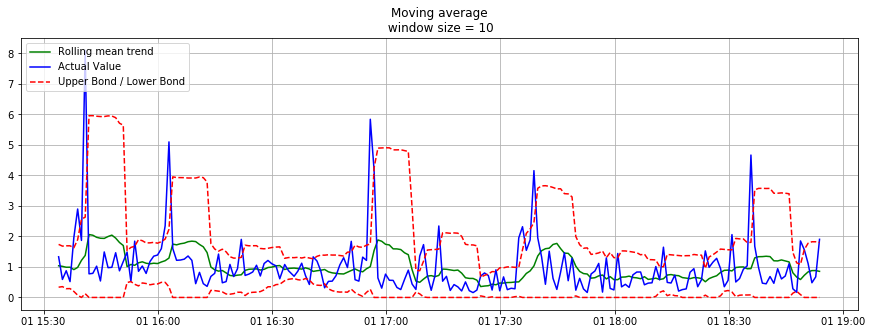

In [4]:
## mid가 67인 데이터에 대하여 그래프 그리기
df = temp_df2[temp_df2['mid']==67]
window = 10
rawdata = list(df.cpu_usage)
testdata = rawdata[window:]
time = list(df.date)[window:]
bound = []
mean_vector = []
for i in range(len(rawdata)-window):
    Series = rawdata[i:i+window]    
    if predictionBound(Series, window) != -1:
        bound.append((max(0,predictionBound(Series, window)[0])\
                      ,min(90,predictionBound(Series, window)[1])))
        mean_vector.append(maPrediction(Series, window))
    else:
        raise ValueError('something wrong happens')

result = []
for i in range(len(bound)):
    upper = bound[i][1]
    lower = bound[i][0]
    if testdata[i] > upper or testdata[i] < lower:
        result.append(0)
    else:
        result.append(1)
print(sum(result)/len(result))

upper = [x[1] for x in bound]
lower = [x[0] for x in bound]

plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(window))
plt.plot(time[:200], mean_vector[:200], "g", label="Rolling mean trend")
plt.plot(time[:200], testdata[:200], "b", label='Actual Value')
plt.plot(time[:200], upper[:200], "r--", label="Upper Bond / Lower Bond")
plt.plot(time[:200], lower[:200], "r--")
plt.legend(loc="upper left")
plt.grid(True)

In [5]:
## 예측값을 구하는데 걸리는 시간
df = temp_df2[temp_df2['mid']==67]
window = 10
rawdata = list(df.cpu_usage)
testdata = rawdata[window:]
time = list(df.date)[window:]
bound = []
mean_vector = []
i = 0
Series = rawdata[i:i+window]

In [9]:
%%timeit
if predictionBound(Series, window) != -1:
    bound.append((max(0,predictionBound(Series, window)[0])\
                  ,min(90,predictionBound(Series, window)[1])))
    mean_vector.append(maPrediction(Series, window))
else:
    raise ValueError('something wrong happens')

292 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
